# Chicago Crime Dataset Analysis

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import geopandas
import datetime
import csv

## Data Sources
Brought in data sets all from the City of Chicago.  The main dataset is has incidents of crime since 2001 to present.  The second one has  socioeconomic indicators such as unemployment rate, poverty rate, hardship index, etc., all by neighborhood.  The third dataset has population by neighborhood in 2010.  We needed this to establish a crime rate for each neighborhood.  The population data was only available as a pdf which was converted to a csv.  The fourth was weather information, and we selected the Illinois file (state11_IL.txt.gz).  The fifth is a linke shape files of Chicago community areas used during the mapping portion.  These files are included in the repository and do not need to be downloaded.  The locations of the data are:

https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2 (click export at the top, save as CSV)

https://data.cityofchicago.org/Health-Human-Services/Census-Data-Selected-socioeconomic-indicators-in-C/kn9c-c2s2

http://www.cityofchicago.org/city/en/depts/dcd/supp_info/community_area_2000and2010censuspopulationcomparisons.html

http://cdiac.ornl.gov/ftp/ushcn_daily/ (state11_IL.txt.gz)

https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6 (needed for geopandas, files are already in the repository)


Read in crime data

In [3]:
df = pd.read_csv("Crimes_-_2001_to_present.csv")

Parse date strings, we found this to be faster than parsing dates while reading in the data

In [4]:
df['Datetime'] = pd.to_datetime(df.Date, format="%m/%d/%Y %I:%M:%S %p")
df['Date'] = df['Datetime'] #used to reconcile different data streams

In [5]:
df3 = pd.read_csv("Census_Data_-_Selected_socioeconomic_indicators_in_Chicago__2008___2012.csv")

In [6]:
df3.rename(columns = {'Community Area Number':'Num'}, inplace = True)

In [7]:
population = pd.read_csv("Census_2010_and_2000_CA_Populations.csv", dtype={'2010':int})

Defined some functions to parse out hour and month crimes were committed

In [8]:
def hr_func(ts):
    return ts.hour

def month_func(ts):
    return ts.month

df['crime_hour'] = df['Date'].apply(hr_func)
df['Month'] = df['Date'].apply(month_func)

df['Day'] = df['Date'].map(lambda x: x.day)
df['Year'] = df['Date'].map(lambda x: x.year)
df['DoW'] = df['Date'].map(lambda x: x.weekday())
df['Datestr'] = df['Date'].map(lambda x: x.date())
df['Counter'] = 1
df['Datestr'] = df['Datestr'].astype('datetime64')
#The field 'Datestr' is being used to reconcile two different workflows
#Datestr is actually a datetime object.

# Crime Over Time

Crime has decreased dramatically over time

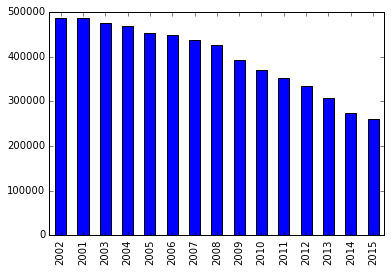

In [10]:
df[df['Year']<2016]['Year'].value_counts().plot(kind = 'bar')

There are 25 police districts, but two of the districts have only had one crime in 15 years? There are no NaNs, but something must be incorrect. There is a source we brought up in the field descriptors that showed those police districts in 2009, so it doesn't seem like redistricting could be the cause of this.

http://home.chicagopolice.org/community/districts/
http://4abpn833c0nr1zvwp7447f2b.wpengine.netdna-cdn.com/wp-content/uploads/2014/11/community_area-1.pdf

We discovered out that there is no 13th or 23rd police district, but I'm not really sure why.  

In [11]:
df['District'].value_counts()

8     414236
11    381782
7     360575
25    352280
6     344945
4     343730
3     310116
2     307940
9     298924
12    294125
19    268275
5     267581
15    266520
18    256917
10    255083
14    239716
1     209067
16    199434
22    198686
24    180525
17    175161
20    105221
31       105
23         1
13         1
Name: District, dtype: int64

Some wards have five times the crime of other wards, however there are no anomalous values

In [13]:
df['Ward'].value_counts()

28    248434
2     207448
24    207164
42    200966
27    194559
20    182165
17    181483
6     174717
3     169164
21    163159
16    158450
34    154734
15    153973
37    146915
8     145797
7     144791
9     135622
5     129564
29    126384
1     105134
4      99586
26     95213
10     93643
32     93246
18     91496
30     77477
31     77075
49     76506
11     75559
14     75245
25     73801
35     73154
46     72963
44     72961
23     71846
13     69825
43     67472
12     66040
22     62295
38     58600
47     56560
36     56490
40     56055
41     55306
50     54979
45     54902
33     54302
48     53851
39     50507
19     48547
Name: Ward, dtype: int64

To see what the daily variation looks like, we sum the count by day and plot over time.

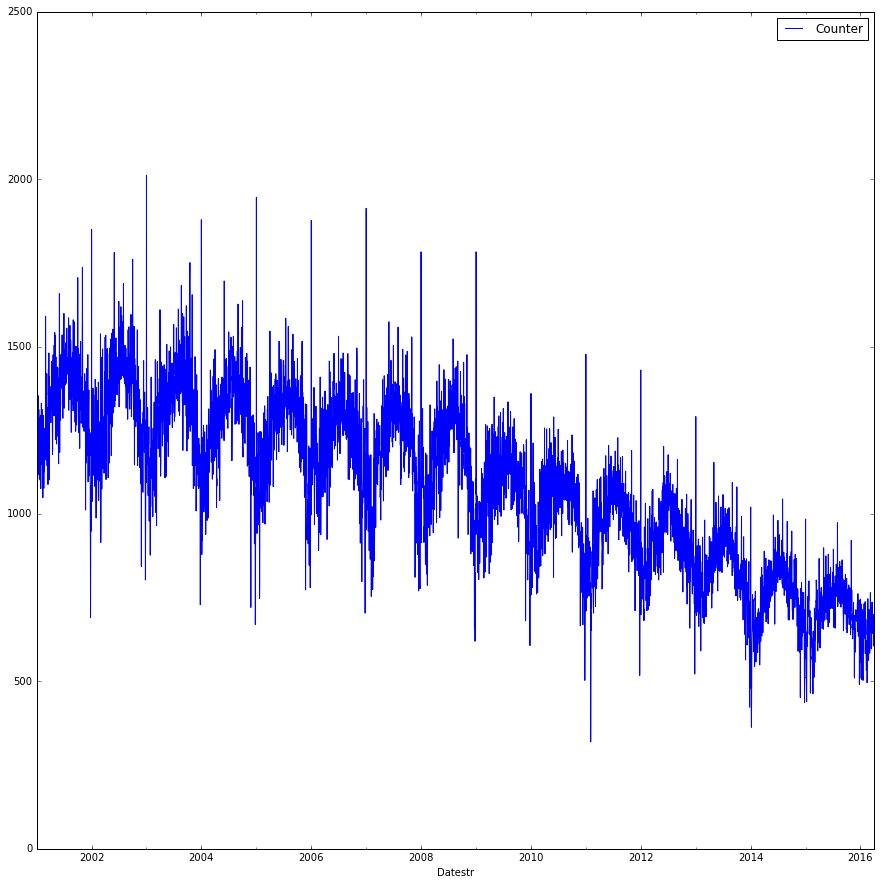

In [15]:
df_byday = df[['Counter', 'Datestr']].groupby('Datestr').aggregate(np.sum)
df_byday.plot(kind='line', figsize=(15,15))

There is a lot of noise, so we'll plot the rolling mean to show the underlying pattern.  The pattern is so strong that we can take the rolling mean out to 100 days and still maintain the same shape.

(array([11323, 11688, 12418, 13149, 13879, 14610, 15340, 16071, 16801, 16889], dtype=int64),
 <a list of 10 Text xticklabel objects>)

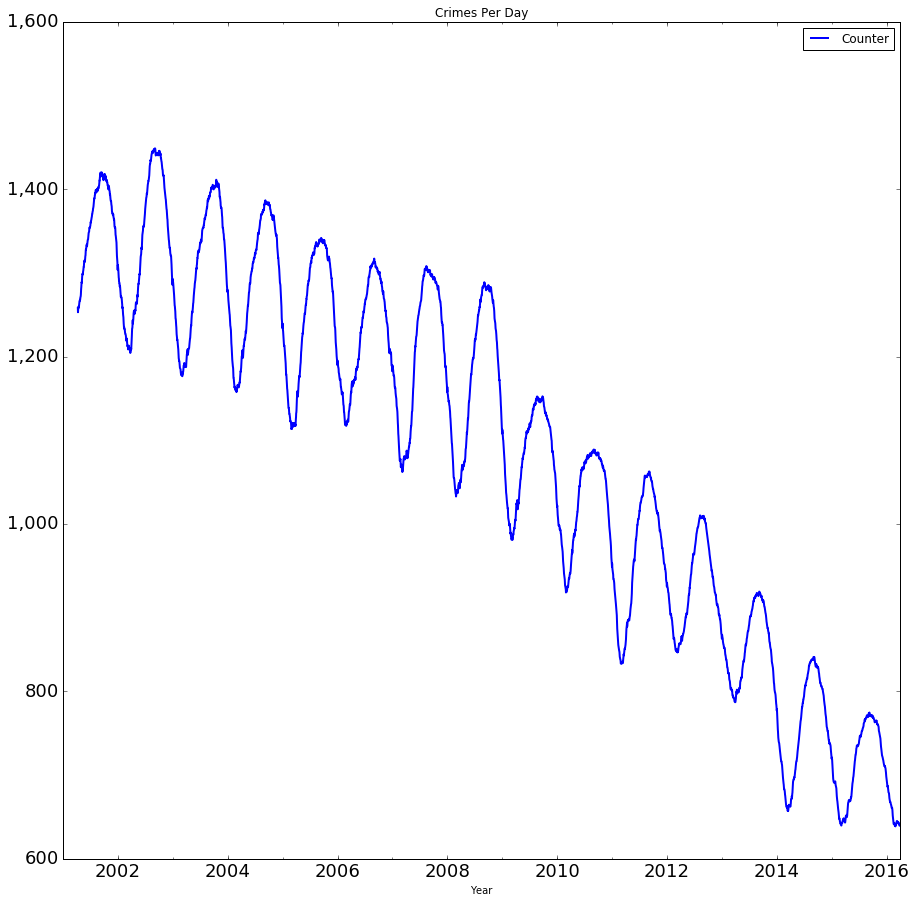

In [16]:
pd.rolling_mean(df_byday, 100).plot(figsize=(15,15), linewidth=2, title='Crimes Per Day')
plt.xlabel('Year')
plt.yticks([600, 800, 1000, 1200, 1400, 1600], ['600', '800', '1,000', '1,200', '1,400', '1,600'], fontsize=18)
plt.xticks(fontsize=18)

Zoomed in on one year to see if all of that variation looks to have a sub-pattern.

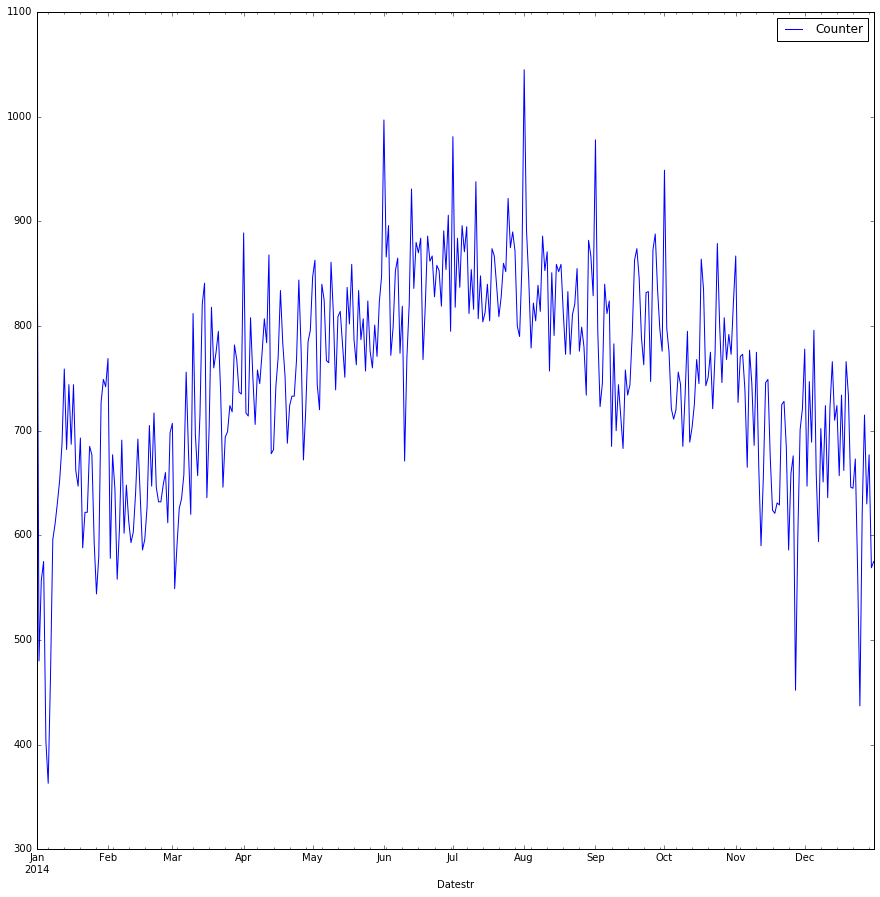

In [17]:
df_byday['2014'].plot(kind='line', figsize=(15,15))

Group by the day of the month and plot. Day 31 is expected to be low since only seven months have 31 days. The only day that is unusually high is the first.

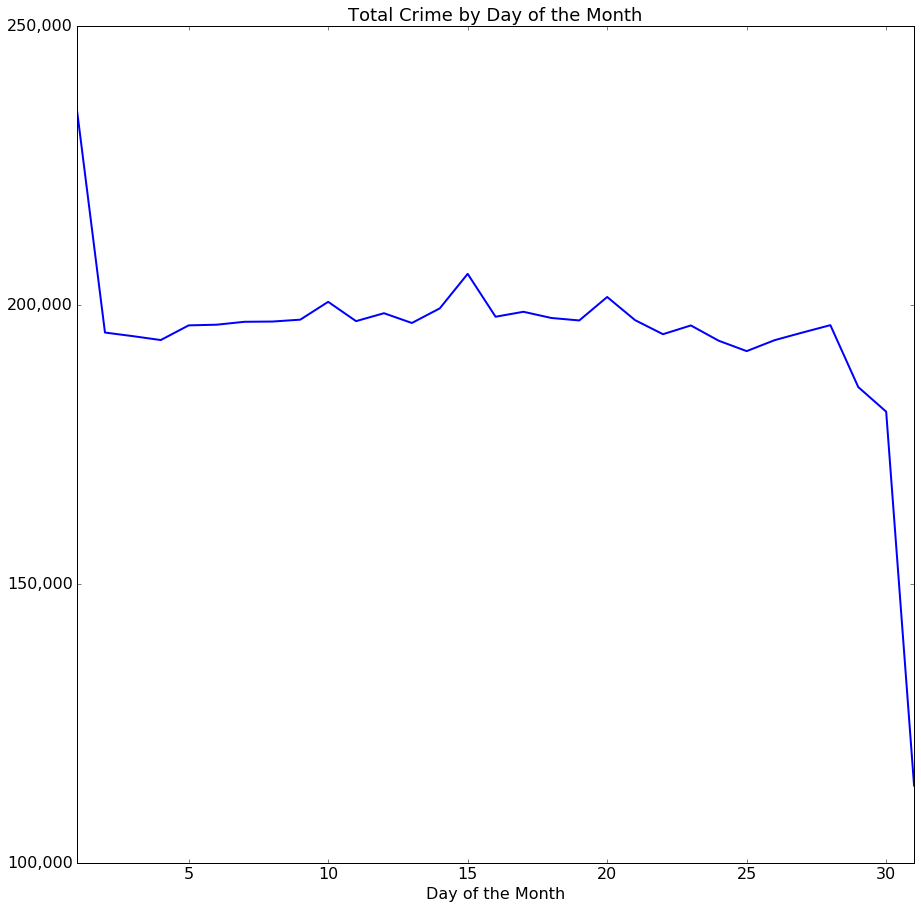

In [18]:
df.groupby('Day')['Counter'].aggregate(np.sum).plot(figsize=(15,15), linewidth=2)
plt.title('Total Crime by Day of the Month', fontsize=18)
locs, labels = plt.yticks()
plt.yticks([100000,150000, 200000, 250000], ['100,000', '150,000', '200,000', '250,000'], fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel('Day of the Month', fontsize=16)

And now we group all complete years by month and sum to see if the seasonal trend is consistent across the whole data set.

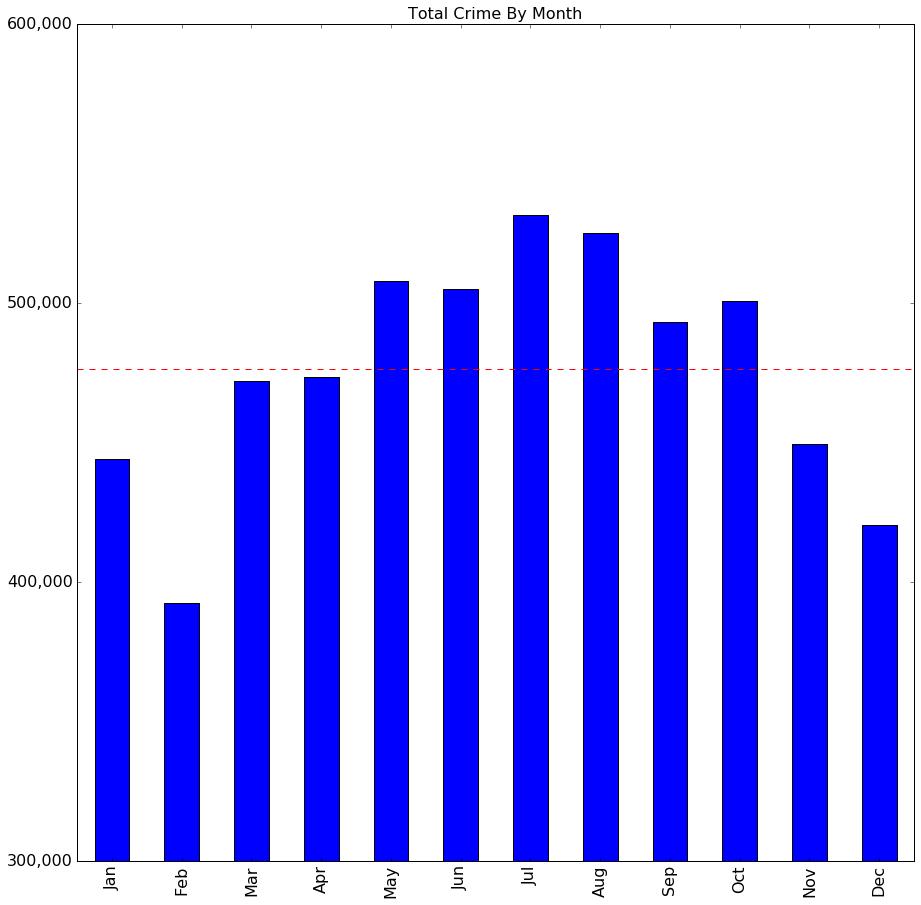

In [19]:
df[df['Date'] <='2015'].groupby('Month')['Counter'].aggregate(np.sum).plot(kind='bar', figsize=(15, 15))
plt.title('Total Crime By Month', fontsize=16)
locs, labels = plt.yticks()
plt.yticks([300000, 400000, 500000, 600000], ['300,000', '400,000', '500,000', '600,000'], fontsize=16)
plt.ylim(300000, 600000)
locs, labels = plt.xticks()
plt.xticks(locs, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=16)
plt.xlabel('')
plt.axhline(df[df['Date'] <='2015'].groupby('Month')['Counter'].aggregate(np.sum).mean(), color='red', linestyle='--')

Next we break down the count of crimes by day of the week.  

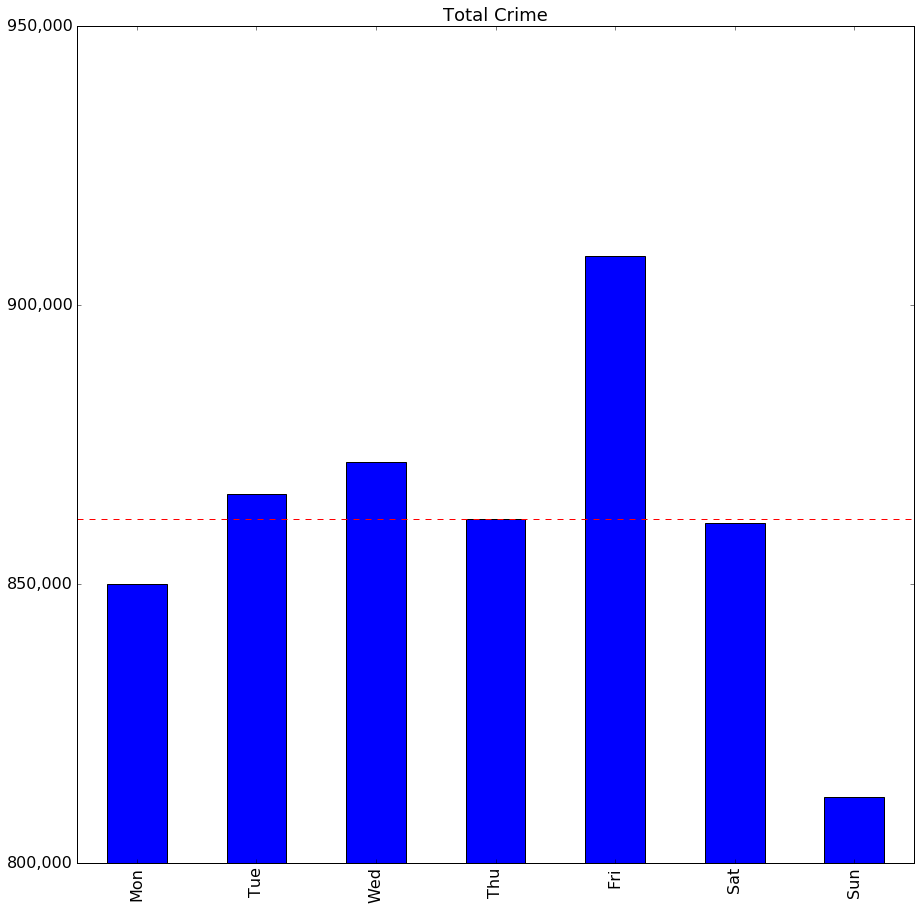

In [20]:
df.groupby('DoW')['Counter'].aggregate(np.sum).plot(kind='bar', figsize=(15,15))
plt.ylim([800000, 950000])
locs, labels = plt.xticks()
plt.xticks(locs, ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=16)
plt.xlabel('')
locs, labels = plt.yticks()
plt.yticks([800000, 850000, 900000, 950000], ['800,000', '850,000', '900,000', '950,000'], fontsize=16)
plt.title('Total Crime', fontsize=18)
plt.axhline(df.groupby('DoW')['Counter'].aggregate(np.sum).mean(), color='red', linestyle='--')

Here we calculate the variance between the min and max of each month

In [21]:
(df[df['Date'] <='2015'].groupby('Month')['Counter'].aggregate(np.sum).max() - \
 df[df['Date'] <='2015'].groupby('Month')['Counter'].aggregate(np.sum).min()) / \
df[df['Date'] <='2015'].groupby('Month')['Counter'].aggregate(np.sum).mean()

0.29249005354658386

Although there is a strong peak on Friday, the largest and smallest values are within 100,000 crimes.
The variance between days of the week is much smaller

In [23]:
(df.groupby('DoW')['Counter'].aggregate(np.sum).max() - \
 df.groupby('DoW')['Counter'].aggregate(np.sum).min()) / \
df.groupby('DoW')['Counter'].aggregate(np.sum).mean()

0.11266294798415318

# Top Crimes

This section was largely exploratory, getting a sense of the top crimes in the dataset and a feel of crime over time

In [24]:
top5crimes = df[(df['Primary Type'] == 'THEFT')|(df['Primary Type'] == 'BATTERY')|(df['Primary Type'] == 'CRIMINAL DAMAGE')|(df['Primary Type'] == 'NARCOTICS')|(df['Primary Type'] == 'ASSAULT')]

In [25]:
theft = df[(df['Primary Type'] == 'THEFT') & (df['Year'] < 2016)]

In [26]:
battery = df[(df['Primary Type'] == 'BATTERY') & (df['Year'] < 2016)]

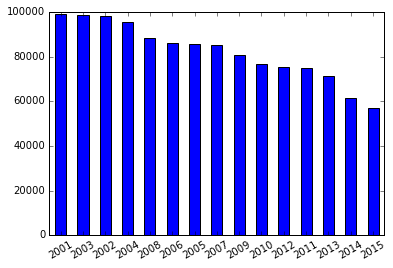

In [28]:
theft['Year'].value_counts().plot(rot = 30, kind = 'bar')

Plot the top fifteen types of crime for report.

([<matplotlib.axis.YTick at 0x1b2f9c28ef0>,
 <a list of 3 Text yticklabel objects>)

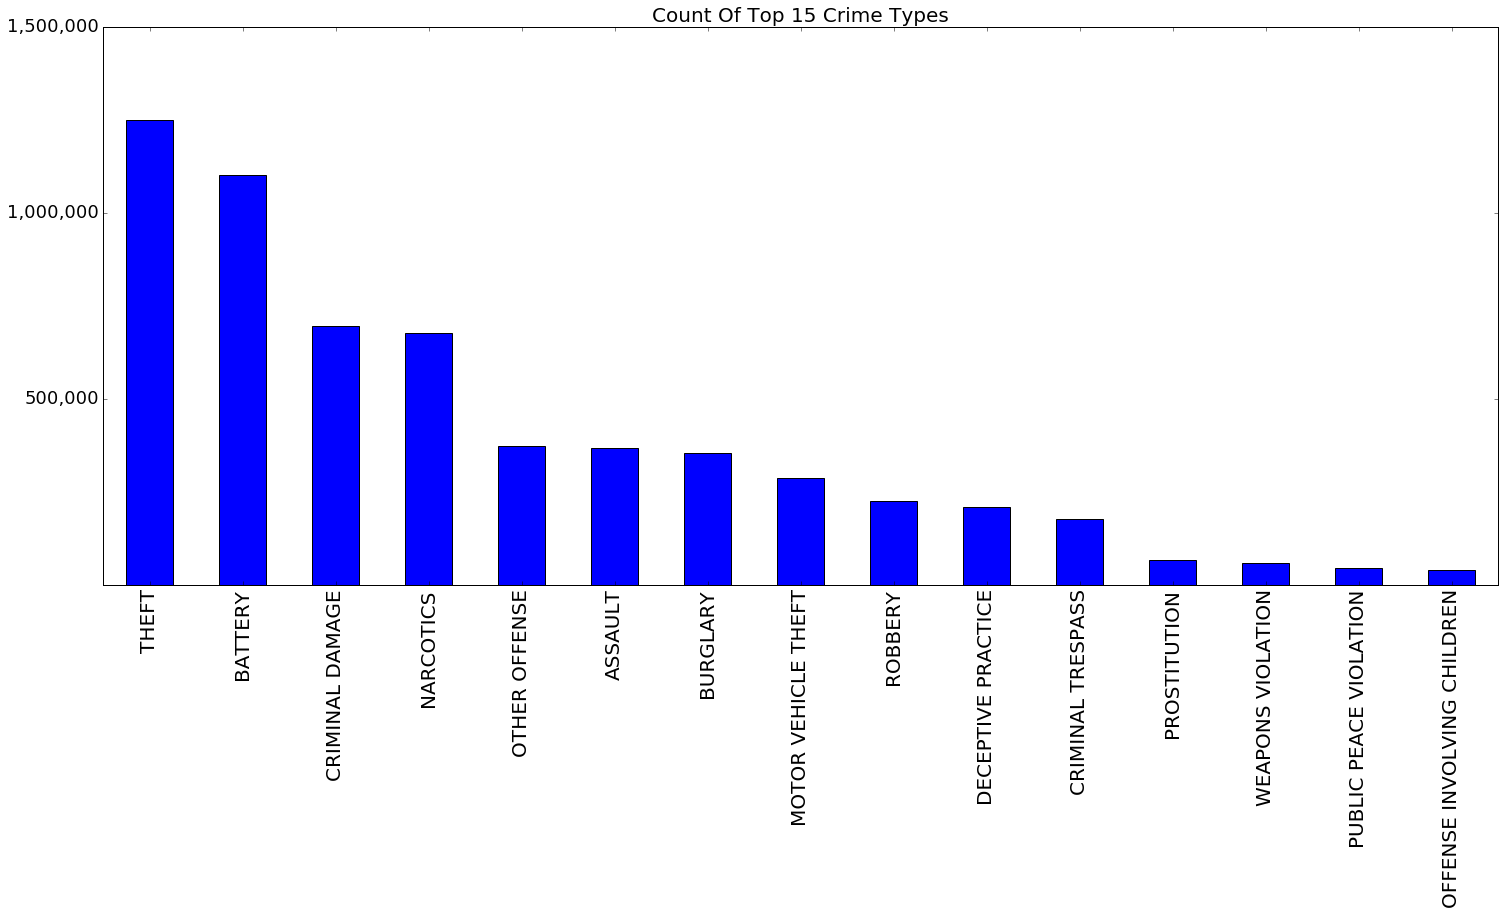

In [29]:
df['Primary Type'].value_counts()[:15].plot(kind='bar', figsize=(25,10), rot=90)
plt.title('Count Of Top 15 Crime Types', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks([500000, 1000000, 1500000], fontsize=18)
locs, labels = plt.yticks()
plt.yticks(locs, ['500,000', '1,000,000', '1,500,000'])

In [30]:
theft.groupby('Year')['Primary Type'].value_counts()

Year  Primary Type
2001  THEFT           99263
2002  THEFT           98327
2003  THEFT           98875
2004  THEFT           95463
2005  THEFT           85685
2006  THEFT           86237
2007  THEFT           85155
2008  THEFT           88430
2009  THEFT           80971
2010  THEFT           76748
2011  THEFT           75133
2012  THEFT           75449
2013  THEFT           71517
2014  THEFT           61508
2015  THEFT           57159
dtype: int64

In [31]:
df['Primary Type'].value_counts()

THEFT                                1248374
BATTERY                              1100146
CRIMINAL DAMAGE                       693907
NARCOTICS                             676191
OTHER OFFENSE                         373068
ASSAULT                               366543
BURGLARY                              353491
MOTOR VEHICLE THEFT                   285586
ROBBERY                               225908
DECEPTIVE PRACTICE                    209757
CRIMINAL TRESPASS                     175571
PROSTITUTION                           66354
WEAPONS VIOLATION                      58434
PUBLIC PEACE VIOLATION                 43854
OFFENSE INVOLVING CHILDREN             38829
CRIM SEXUAL ASSAULT                    22473
SEX OFFENSE                            22103
GAMBLING                               13867
LIQUOR LAW VIOLATION                   13461
INTERFERENCE WITH PUBLIC OFFICER       12135
ARSON                                   9985
HOMICIDE                                7584
KIDNAPPING

Theft and Battery are cleary the top two crimes represented in the dataset followed by criminal damage and narcotics

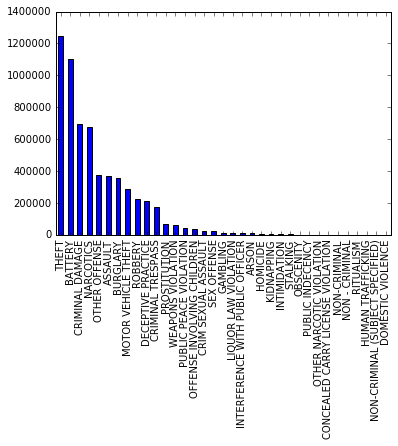

In [32]:
df['Primary Type'].value_counts().plot(kind = 'bar')

Although crime is decreasing overall, let's see if each type of crime decreases the same.  News reports are focusing on very high rates of homicide and gun violence and that appears to be true.  In order to compare different values we index each type against its average, so a score of 100 represents an average incidence of crime.  

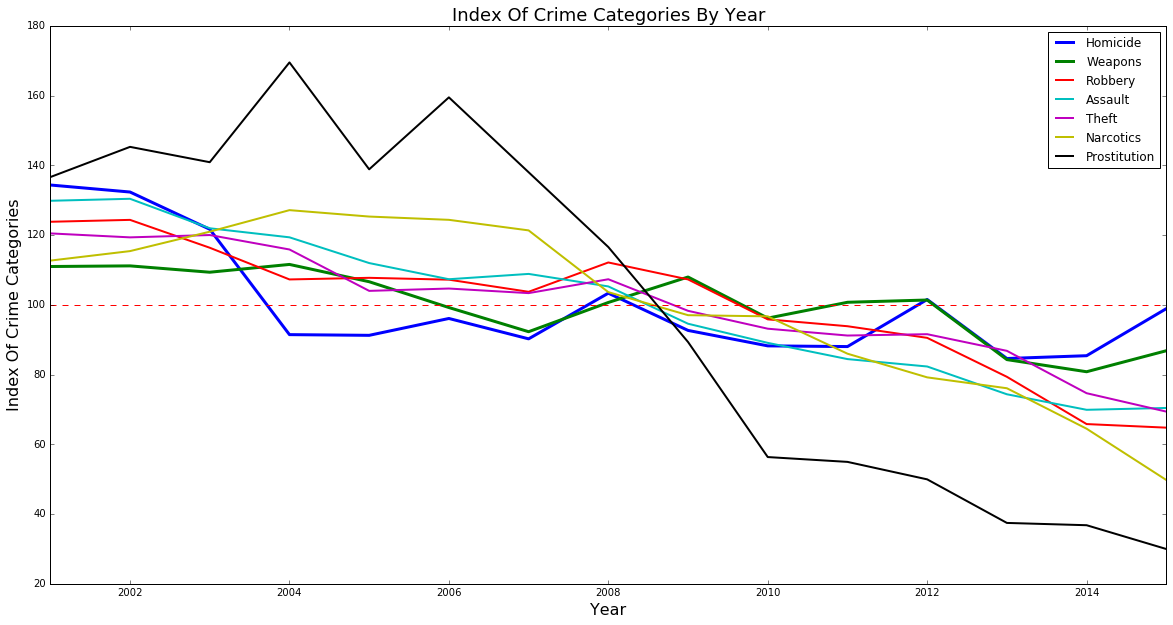

In [33]:
(df[(df['Primary Type'] == "HOMICIDE") & (df['Datetime'] < '2016')].groupby('Year')['Counter'].aggregate(np.sum) / \
df[(df['Primary Type'] == "HOMICIDE") & (df['Datetime'] < '2016')].groupby('Year')['Counter'].aggregate(np.sum).mean() * 100).plot(figsize=(20, 10), linewidth=3)

(df[(df['Primary Type'] == "WEAPONS VIOLATION") & (df['Datetime'] < '2016')].groupby('Year')['Counter'].aggregate(np.sum) / \
df[(df['Primary Type'] == "WEAPONS VIOLATION") & (df['Datetime'] < '2016')].groupby('Year')['Counter'].aggregate(np.sum).mean() * 100).plot(linewidth=3)

(df[(df['Primary Type'] == "ROBBERY") & (df['Datetime'] < '2016')].groupby('Year')['Counter'].aggregate(np.sum) / \
df[(df['Primary Type'] == "ROBBERY") & (df['Datetime'] < '2016')].groupby('Year')['Counter'].aggregate(np.sum).mean() * 100).plot(linewidth=2)

(df[(df['Primary Type'] == "ASSAULT") & (df['Datetime'] < '2016')].groupby('Year')['Counter'].aggregate(np.sum) / \
df[(df['Primary Type'] == "ASSAULT") & (df['Datetime'] < '2016')].groupby('Year')['Counter'].aggregate(np.sum).mean() * 100).plot(linewidth=2)

(df[(df['Primary Type'] == "THEFT") & (df['Datetime'] < '2016')].groupby('Year')['Counter'].aggregate(np.sum) / \
df[(df['Primary Type'] == "THEFT") & (df['Datetime'] < '2016')].groupby('Year')['Counter'].aggregate(np.sum).mean() * 100).plot(linewidth=2)

(df[(df['Primary Type'] == "NARCOTICS") & (df['Datetime'] < '2016')].groupby('Year')['Counter'].aggregate(np.sum) / \
 df[(df['Primary Type'] == "NARCOTICS") & (df['Datetime'] < '2016')].groupby('Year')['Counter'].aggregate(np.sum).mean() * 100).plot(linewidth=2)

(df[(df['Primary Type'] == "PROSTITUTION") & (df['Datetime'] < '2016')].groupby('Year')['Counter'].aggregate(np.sum) / \
 df[(df['Primary Type'] == "PROSTITUTION") & (df['Datetime'] < '2016')].groupby('Year')['Counter'].aggregate(np.sum).mean() * 100).plot(linewidth=2)

plt.title('Index Of Crime Categories By Year', fontsize=18)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Index Of Crime Categories', fontsize=16)
plt.legend(['Homicide', 'Weapons', 'Robbery', 'Assault', 'Theft', 'Narcotics', 'Prostitution'])
plt.axhline(100, color='red', linestyle='--')

Show each description that falls under each primary type.

In [34]:
primary_types = df['Primary Type'].unique()
for x in primary_types:
    print(x, '\n', df['Description'][df['Primary Type'] == x].unique())

OTHER OFFENSE 
 ['HARASSMENT BY ELECTRONIC MEANS' 'ANIMAL ABUSE/NEGLECT' 'PAROLE VIOLATION'
 'HARASSMENT BY TELEPHONE' 'VEHICLE TITLE/REG OFFENSE' 'LICENSE VIOLATION'
 'TELEPHONE THREAT' 'OTHER VEHICLE OFFENSE' 'OTHER CRIME AGAINST PERSON'
 'VIOLATE ORDER OF PROTECTION' 'FALSE/STOLEN/ALTERED TRP'
 'OTHER CRIME INVOLVING PROPERTY' 'OTHER WEAPONS VIOLATION'
 'PROBATION VIOLATION' 'SEX OFFENDER: FAIL TO REGISTER'
 'OBSCENE TELEPHONE CALLS' 'VIOLENT OFFENDER: ANNUAL REGISTRATION'
 'HAZARDOUS MATERIALS VIOLATION' 'ARSONIST: ANNUAL REGISTRATION'
 'GUN OFFENDER: DUTY TO REGISTER' 'VIOLATION OF CIVIL NO CONTACT ORDER'
 'GUN OFFENDER: ANNUAL REGISTRATION'
 'GUN OFFENDER: DUTY TO REPORT CHANGE OF INFORMATION'
 'OTHER ARSON/EXPLOSIVE INCIDENT' 'VIO BAIL BOND: DOM VIOLENCE'
 'SEX OFFENDER: PROHIBITED ZONE' 'SEX OFFENDER: FAIL REG NEW ADD'
 'MONEY LAUNDERING' 'VIOLATION GPS MONITORING DEVICE'
 'BOARD PLANE WITH WEAPON' 'TAMPER WITH MOTOR VEHICLE'
 'VIOLATION OF SMOKING BAN' 'ABUSE/NEGLECT: CARE FAC

# Crime Hours

Originally we were planning to setup the crime and time analysis with buckets for early morning, morning, afternoon and evening, but we found that including every hour was more interesting and showed a more complete picture of crime by hour

In [35]:
ranges = [0,6,12,18,24]
labels = ['Early Morning','Morning','Early Afternoon','Evening']

In [36]:
df['Time_Group'] = pd.cut(df['crime_hour'],ranges, labels=labels).astype('category')

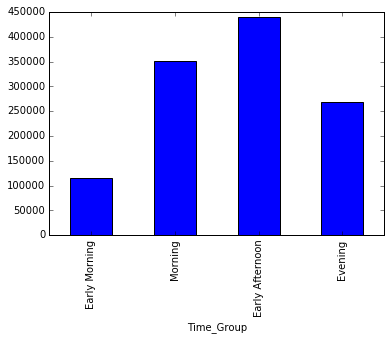

In [37]:
theft_hours = df[df['Primary Type'] == 'THEFT']
theft_hours.groupby('Time_Group')['Primary Type'].count().plot(kind='bar')

The most popular hours for crime are 8PM, 7PM, and 12PM.  Interesting that we see a spike in the middle of the day compared to other hours.  Crime is very low during the early morning periods from 1AM to 5AM likely because most people are still asleep.

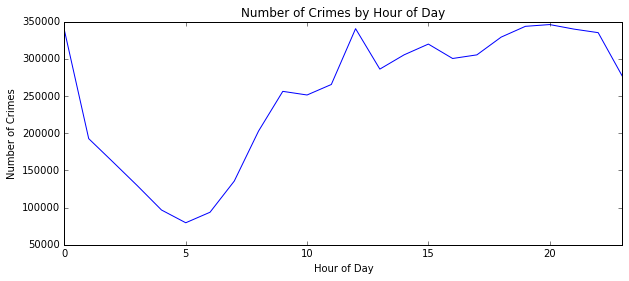

In [9]:
timer = df['crime_hour'].value_counts()
df_hour = timer.to_frame()
df_hour.sort_index().plot(figsize = (10,4), legend = False, title = "Number of Crimes by Hour of Day")
plt.xlabel('Hour of Day')
plt.ylabel('Number of Crimes')

In [10]:
df_hour.sort_values('crime_hour', ascending = False)

,crime_hour
20,346016
19,343647
12,340496
21,339915
0,338078
22,335135
18,329148
15,319781
14,305327
17,305285


Noon Crime is higher due to a high proportion of Theft during that hour

In [40]:
noon_crime = df[df['crime_hour'] == 12]
noon_counts = noon_crime['Primary Type'].value_counts().sort_values(ascending = False)
noon_counts.head()

THEFT              87862
BATTERY            47860
NARCOTICS          44764
OTHER OFFENSE      25817
CRIMINAL DAMAGE    25202
Name: Primary Type, dtype: int64

25% of crimes commmited in the noon hour are thefts

In [41]:
noon_counts/noon_counts.sum()

THEFT                                0.258041
BATTERY                              0.140560
NARCOTICS                            0.131467
OTHER OFFENSE                        0.075822
CRIMINAL DAMAGE                      0.074016
DECEPTIVE PRACTICE                   0.070474
ASSAULT                              0.062250
BURGLARY                             0.060747
MOTOR VEHICLE THEFT                  0.034958
CRIMINAL TRESPASS                    0.028508
ROBBERY                              0.024144
PUBLIC PEACE VIOLATION               0.007184
WEAPONS VIOLATION                    0.006899
OFFENSE INVOLVING CHILDREN           0.006723
PROSTITUTION                         0.003985
SEX OFFENSE                          0.003542
GAMBLING                             0.002432
CRIM SEXUAL ASSAULT                  0.002179
INTERFERENCE WITH PUBLIC OFFICER     0.001492
LIQUOR LAW VIOLATION                 0.000990
KIDNAPPING                           0.000852
INTIMIDATION                      

There wasn't a clear crime type driver for the 8PM hour

In [42]:
crime_20 = df[df['crime_hour'] == 20]
count_20 = crime_20['Primary Type'].value_counts().sort_values(ascending = False)
count_20.head()

BATTERY            61098
THEFT              57943
NARCOTICS          56728
CRIMINAL DAMAGE    42036
ASSAULT            20953
Name: Primary Type, dtype: int64

In [43]:
count_20/count_20.sum()

BATTERY                              0.176576
THEFT                                0.167458
NARCOTICS                            0.163946
CRIMINAL DAMAGE                      0.121486
ASSAULT                              0.060555
OTHER OFFENSE                        0.056703
MOTOR VEHICLE THEFT                  0.051165
BURGLARY                             0.039331
ROBBERY                              0.039200
CRIMINAL TRESPASS                    0.033984
PROSTITUTION                         0.023013
DECEPTIVE PRACTICE                   0.018447
WEAPONS VIOLATION                    0.012560
PUBLIC PEACE VIOLATION               0.009358
OFFENSE INVOLVING CHILDREN           0.005638
GAMBLING                             0.004254
LIQUOR LAW VIOLATION                 0.004127
CRIM SEXUAL ASSAULT                  0.002899
SEX OFFENSE                          0.002870
INTERFERENCE WITH PUBLIC OFFICER     0.002477
ARSON                                0.001150
HOMICIDE                          

In [44]:
not_noon = df[df['crime_hour'] != 12]
not_noon_counts = not_noon['Primary Type'].value_counts().sort_values(ascending = False)
not_noon_counts.head()

THEFT              1160512
BATTERY            1052286
CRIMINAL DAMAGE     668705
NARCOTICS           631427
OTHER OFFENSE       347251
Name: Primary Type, dtype: int64

Thefts at noon overindex compared to the rest of the dataset which is only 20% theft related

In [45]:
not_noon_counts/not_noon_counts.sum()

THEFT                                2.039387e-01
BATTERY                              1.849200e-01
CRIMINAL DAMAGE                      1.175127e-01
NARCOTICS                            1.109617e-01
OTHER OFFENSE                        6.102301e-02
ASSAULT                              6.068841e-02
BURGLARY                             5.848474e-02
MOTOR VEHICLE THEFT                  4.809478e-02
ROBBERY                              3.825451e-02
DECEPTIVE PRACTICE                   3.264410e-02
CRIMINAL TRESPASS                    2.914756e-02
PROSTITUTION                         1.142203e-02
WEAPONS VIOLATION                    9.855912e-03
PUBLIC PEACE VIOLATION               7.276698e-03
OFFENSE INVOLVING CHILDREN           6.421236e-03
CRIM SEXUAL ASSAULT                  3.818826e-03
SEX OFFENSE                          3.672265e-03
LIQUOR LAW VIOLATION                 2.306303e-03
GAMBLING                             2.291366e-03
INTERFERENCE WITH PUBLIC OFFICER     2.043232e-03


In [46]:
theft_time = df[df['Primary Type'] == 'THEFT']
battery_time = df[df['Primary Type'] == 'BATTERY']
narcos_time = df[df['Primary Type'] == 'NARCOTICS']
prostitution_time = df[df['Primary Type'] == 'PROSTITUTION']
MVT = df[df['Primary Type'] == 'MOTOR VEHICLE THEFT']

Theft has a high spike at noon, potentially this is the most likely hour a theif will encounter a victim, could also be a function of when the crime was reported.  Battery has a steady increase from morning to late in the evening.  Nacrotics crimes occur in waves with the first wave late in the morning and the second wave starting early in the evening.  Protsituiton and Vehicle Theft are largely popular during the late night.

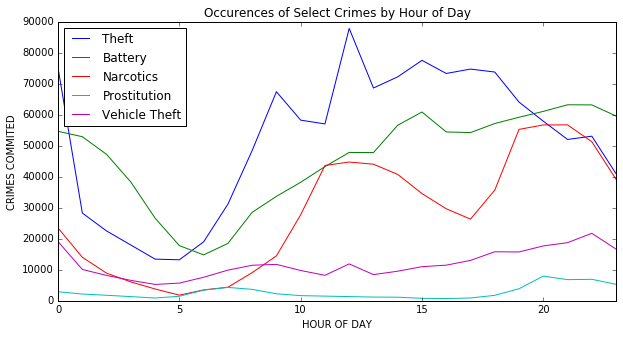

In [47]:
theft_time.groupby('crime_hour')['Primary Type'].count().plot(figsize=(10,5), title = 'Occurences of Select Crimes by Hour of Day')
battery_time.groupby('crime_hour')['Primary Type'].count().plot()
narcos_time.groupby('crime_hour')['Primary Type'].count().plot()
prostitution_time.groupby('crime_hour')['Primary Type'].count().plot()
MVT.groupby('crime_hour')['Primary Type'].count().plot()
plt.xlabel('HOUR OF DAY')
plt.ylabel('CRIMES COMMITED')
plt.legend(('Theft', 'Battery', 'Narcotics', 'Prostitution','Vehicle Theft',), loc = 'best')

# Crime and Socioeconomic Factors

We setup a new dataframe for the socioeconomic comparison.  First we filtered the crime dataset for only crimes commited in 2010.  Then we merged the population and socioeconomic data to get the crime_pop_socio dataframe

In [11]:
df_2010 = df[df.Year == 2010]
crimes_by_ca = df_2010.groupby('Community Area')['Community Area'].count()
crimes_by_ca = crimes_by_ca.to_frame('Crimes')
crimes_by_ca['Num'] = crimes_by_ca.index

In [12]:
crime_pop = pd.merge(crimes_by_ca, population, on = 'Num', how = 'left')

In [13]:
crime_pop_socio = pd.merge(crime_pop, df3, on = 'Num', how = 'left')

In [14]:
crime_pop_socio.dtypes

Crimes                                            int64
Num                                             float64
Community Area                                   object
2010                                            float64
2000                                            float64
Difference                                      float64
Percentage                                       object
COMMUNITY AREA NAME                              object
PERCENT OF HOUSING CROWDED                      float64
PERCENT HOUSEHOLDS BELOW POVERTY                float64
PERCENT AGED 16+ UNEMPLOYED                     float64
PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA    float64
PERCENT AGED UNDER 18 OR OVER 64                float64
PER CAPITA INCOME                               float64
HARDSHIP INDEX                                  float64
dtype: object

To get a crime rate we created the crime per 100 persons column

In [15]:
crime_pop_socio['Crime Per 100 Persons'] = crime_pop_socio['Crimes']/crime_pop_socio['2010']*100

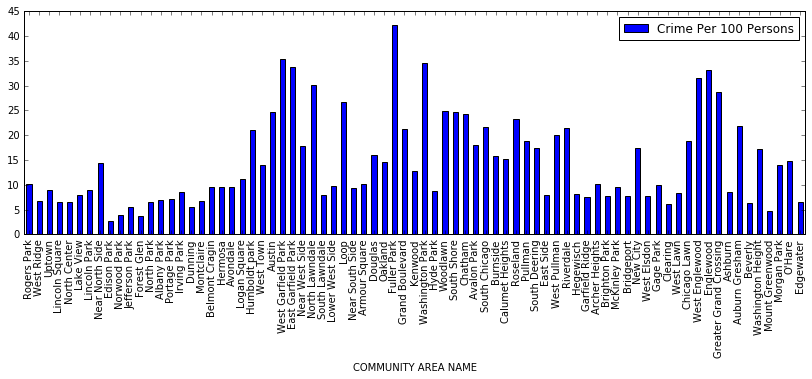

In [16]:
crime_pop_socio[crime_pop_socio['Num'] > 0].plot(x='COMMUNITY AREA NAME', y='Crime Per 100 Persons', rot =90, figsize=(14,4), kind = 'bar')

Crime rate in the Fuller Park Neighborhood is very high with 42.24 incidents of crime per every 100 persons

In [17]:
crime_pop_socio['Crime Per 100 Persons'].sort_values(ascending=False).head()

37    42.246175
26    35.414699
40    34.582231
27    33.830894
68    33.147387
Name: Crime Per 100 Persons, dtype: float64

Originally I was planning to show graphs with each of the socioeconomic indicators by neighborhood but found that the correlation scatter plots showed this information more approriately 

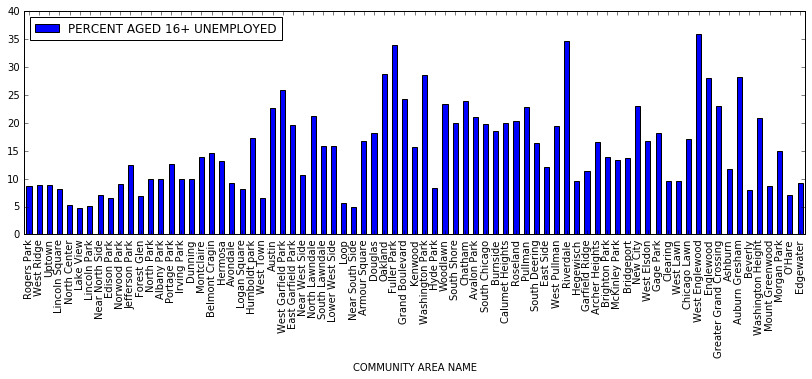

In [18]:
crime_pop_socio[crime_pop_socio['Num'] > 0].plot(x='COMMUNITY AREA NAME', y='PERCENT AGED 16+ UNEMPLOYED', rot =90, figsize=(14,4), kind = 'bar')

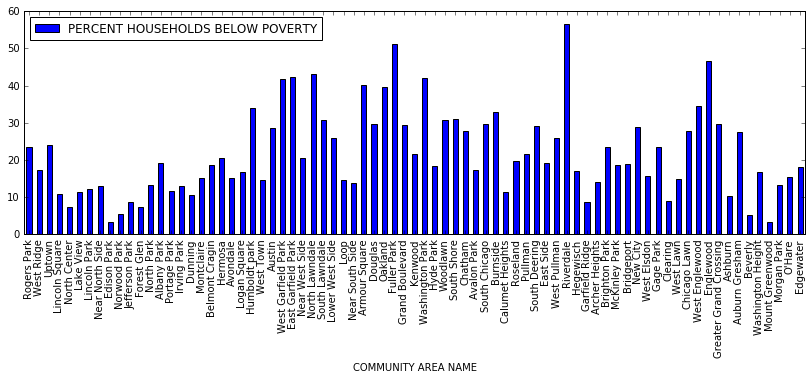

In [19]:
crime_pop_socio[crime_pop_socio['Num'] > 0].plot(x='COMMUNITY AREA NAME', y='PERCENT HOUSEHOLDS BELOW POVERTY', rot =90, figsize=(14,4), kind = 'bar')

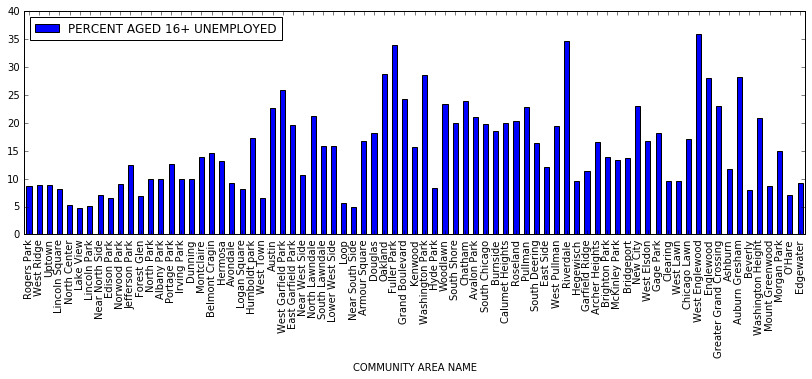

In [38]:
crime_pop_socio[crime_pop_socio['Num'] > 0].plot(x='COMMUNITY AREA NAME', y='PERCENT AGED 16+ UNEMPLOYED', rot =90, figsize=(14,4), kind = 'bar')

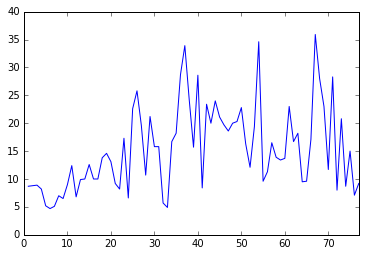

In [39]:
crime_pop_socio['PERCENT AGED 16+ UNEMPLOYED'].plot()

Looks like we have a fairly strong positive correlation between crimes per person and unemployment rate

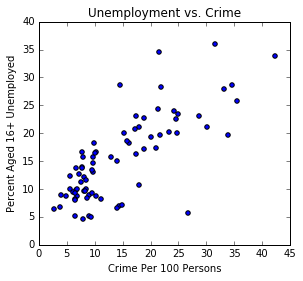

In [40]:
crime_pop_socio.plot(x='Crime Per 100 Persons', y = 'PERCENT AGED 16+ UNEMPLOYED', kind='scatter', figsize = (4.5,4), title = 'Unemployment vs. Crime')
plt.xlabel('Crime Per 100 Persons')
plt.ylabel('Percent Aged 16+ Unemployed')

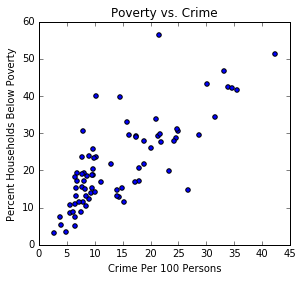

In [41]:
crime_pop_socio.plot(x='Crime Per 100 Persons', y = 'PERCENT HOUSEHOLDS BELOW POVERTY', kind='scatter', figsize = (4.5,4), title = 'Poverty vs. Crime')
plt.xlabel('Crime Per 100 Persons')
plt.ylabel('Percent Households Below Poverty')

In [42]:
crime_pop_socio.columns

Index(['Crimes', 'Num', 'Community Area', '2010', '2000', 'Difference',
       'Percentage', 'COMMUNITY AREA NAME', 'PERCENT OF HOUSING CROWDED',
       'PERCENT HOUSEHOLDS BELOW POVERTY', 'PERCENT AGED 16+ UNEMPLOYED',
       'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA',
       'PERCENT AGED UNDER 18 OR OVER 64', 'PER CAPITA INCOME ',
       'HARDSHIP INDEX', 'Crime Per 100 Persons'],
      dtype='object')

We setup a new dataframe with only the columns we were interested in showing correlation

In [43]:
corr_crime_unemployment = crime_pop_socio[['Crime Per 100 Persons','PERCENT AGED 16+ UNEMPLOYED','PERCENT HOUSEHOLDS BELOW POVERTY','PERCENT OF HOUSING CROWDED','PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA','PER CAPITA INCOME ','HARDSHIP INDEX']]

In [44]:
correl_all = corr_crime_unemployment.corr()

Correlation for all socioeconomic indicators in the data set

In [45]:
correl_all[0:1]

,Crime Per 100 Persons,PERCENT AGED 16+ UNEMPLOYED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT OF HOUSING CROWDED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PER CAPITA INCOME,HARDSHIP INDEX
Crime Per 100 Persons,1,0.763517,0.771436,0.007852,0.079424,-0.337601,0.550902


Not Very Strong Correlation for crime and per capita incom

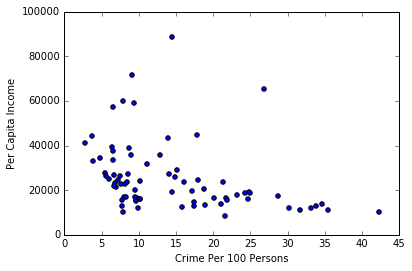

In [47]:
plt.scatter(crime_pop_socio['Crime Per 100 Persons'], crime_pop_socio['PER CAPITA INCOME '])
plt.xlabel('Crime Per 100 Persons')
plt.ylabel('Per Capita Income')

Positive correlation between crime and percent of housing crowded

# Crime Mapping

Create a new coloumn 'Street Name' by striping the building number. This new column can be used to find on which street , any kind of crime is more likely to happen

In [48]:
df['Street Name'] = df['Block'].map(lambda x: str(x)[6:])

We want to look at where assault is most common.

In [49]:
assault = df[df['Primary Type'] == 'ASSAULT']

In [50]:
assault.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,crime_hour,Month,Time_Group,Street Name
3,10465466,HZ204931,2016-03-28 23:30:00,015XX N LEAMINGTON AVE,0560,ASSAULT,SIMPLE,RESIDENCE,False,False,...,1909795,2016,04/04/2016 03:52:23 PM,41.908545,-87.754697,"(41.908545164, -87.754697111)",23,3,Evening,N LEAMINGTON AVE
6,10465545,HZ204983,2016-03-28 23:30:00,006XX N CLARK ST,0560,ASSAULT,SIMPLE,STREET,False,False,...,1904549,2016,04/04/2016 03:52:23 PM,41.893460,-87.631172,"(41.893460016, -87.631171841)",23,3,Evening,N CLARK ST
10,10465541,HZ204902,2016-03-28 23:20:00,035XX W FRANKLIN BLVD,051A,ASSAULT,AGGRAVATED: HANDGUN,ALLEY,False,False,...,1903105,2016,04/04/2016 03:52:23 PM,41.889978,-87.714752,"(41.889977968, -87.714751898)",23,3,Evening,W FRANKLIN BLVD
26,10465488,HZ204919,2016-03-28 22:50:00,062XX W 55TH ST,0554,ASSAULT,AGG PO HANDS NO/MIN INJURY,APARTMENT,True,False,...,1867445,2016,04/04/2016 03:52:23 PM,41.792437,-87.777290,"(41.792437144, -87.777290384)",22,3,Evening,W 55TH ST
28,10465479,HZ204926,2016-03-28 22:50:00,062XX W 55TH ST,0560,ASSAULT,SIMPLE,APARTMENT,True,False,...,1867445,2016,04/04/2016 03:52:23 PM,41.792437,-87.777290,"(41.792437144, -87.777290384)",22,3,Evening,W 55TH ST


In [51]:
assault.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location', 'crime_hour', 'Month', 'Time_Group', 'Street Name'],
      dtype='object')

In [52]:
assault['Street Name'].head()

3     N LEAMINGTON AVE
6           N CLARK ST
10     W FRANKLIN BLVD
26           W 55TH ST
28           W 55TH ST
Name: Street Name, dtype: object

In [53]:
assault['Street Name'].value_counts()

S STATE ST                       4095
S MICHIGAN AVE                   3619
S HALSTED ST                     3241
S DR MARTIN LUTHER KING JR DR    3225
S COTTAGE GROVE AVE              2732
S ASHLAND AVE                    2732
W MADISON ST                     2647
S WABASH AVE                     2114
W NORTH AVE                      2106
S INDIANA AVE                    2010
W JACKSON BLVD                   1983
S WESTERN AVE                    1974
W DIVISION ST                    1936
N CLARK ST                       1912
N SHERIDAN RD                    1871
S MORGAN ST                      1777
S RACINE AVE                     1759
S MAY ST                         1740
S LAFLIN ST                      1728
W WASHINGTON BLVD                1714
S KEDZIE AVE                     1709
W CHICAGO AVE                    1670
N MILWAUKEE AVE                  1669
S UNION AVE                      1655
W 63RD ST                        1606
S PULASKI RD                     1576
S WOOD ST   

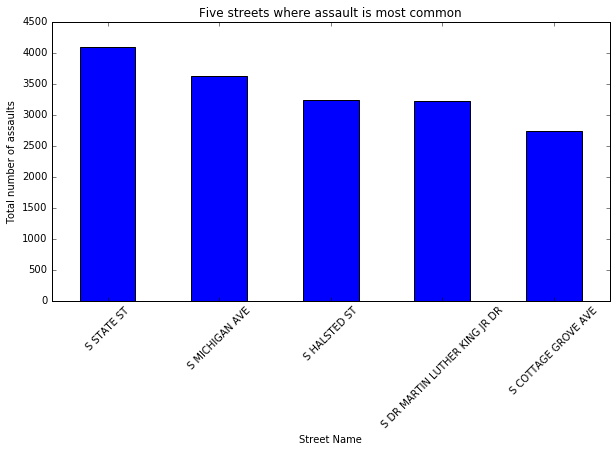

In [54]:
assault_plot = assault['Street Name'].value_counts().head().plot(kind='bar', rot = 45, figsize = (10,5),
                                                                 title = 'Five streets where assault is most common')
assault_plot.set_xlabel('Street Name')
assault_plot.set_ylabel('Total number of assaults')

Find the maximum number of a particular kind of crime that has happened on a given street

In [55]:
crimes_street_map = df.groupby(['Street Name','Primary Type'])

In [56]:
max_crimes = crimes_street_map['Street Name'].value_counts().sort_values(axis=0,ascending = False)

In [57]:
max_crimes.head()

Street Name     Primary Type  Street Name   
N CLARK ST      THEFT         N CLARK ST        17569
N STATE ST      THEFT         N STATE ST        17314
N MICHIGAN AVE  THEFT         N MICHIGAN AVE    15993
W NORTH AVE     THEFT         W NORTH AVE       15099
S STATE ST      THEFT         S STATE ST        14573
dtype: int64

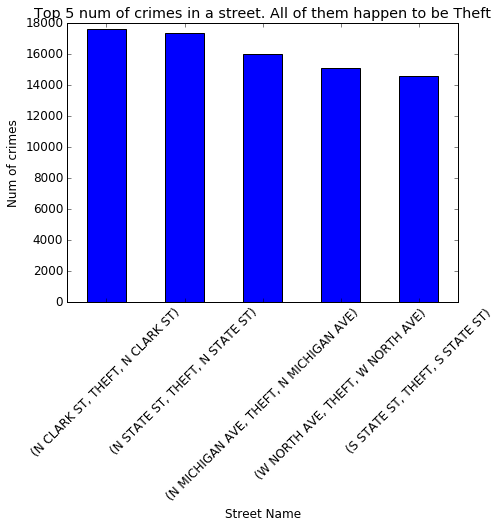

In [58]:
max_crimes_plot = max_crimes.head().plot(kind = 'bar',figsize = (7,5), rot = 45, title = "Top 5 num of crimes in a street. All of them happen to be Theft")
max_crimes_plot.set_xlabel("Street Name")
max_crimes_plot.set_ylabel("Num of crimes")
matplotlib.rcParams.update({'font.size': 12})

Plot to show the region (X Coordniate, Y Coordinate) with more crime on a Chicago map

In [60]:
latitude = df['Latitude'].value_counts()
latitude = pd.DataFrame(latitude)
latitude.columns = ['Count']
latitude['Latitude'] = latitude.index
latitude.head()

,Count,Latitude
41.754593,4071,41.754593
41.976290,3515,41.976290
41.883500,3208,41.883500
41.909664,2289,41.909664
41.897895,2164,41.897895


In [61]:
longitude = df['Longitude'].value_counts()
longitude = pd.DataFrame(longitude)
longitude.columns = ['Count']
longitude['Longitude'] = longitude.index
longitude.head()

,Count,Longitude
-87.741529,4071,-87.741529
-87.905227,3515,-87.905227
-87.627877,3208,-87.627877
-87.742729,2289,-87.742729
-87.624097,2165,-87.624097


In [62]:
location = df['Location'].value_counts()
location = pd.DataFrame(location)
location.columns = ['Count']
location['Location'] = location.index
location['Index'] = np.arange(len(location['Location']))
location.set_index('Index', inplace =True)
location = location.head(100)
crime_location = location.head(100)["Location"]
def extract_x_y(t_location, latitude):
    loc_x = list()
    loc_y = list()
    for i in range(len(t_location)):
        [x,y] = eval(t_location[i])
        loc_x.append(x)
        loc_y.append(y)
    if latitude:
        return (loc_y)
    else:
        return (loc_x)

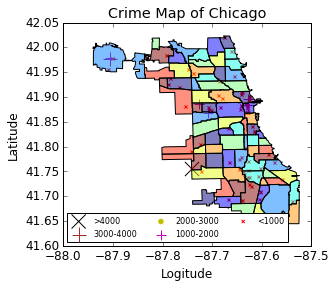

In [63]:
from pandas.tools.plotting import plot_frame
boros = geopandas.GeoDataFrame.from_file('chicago.shp')
boros.ix[0]

boros.plot()
plt.rcParams["figure.figsize"]  = (20,20)

colors = ['b', 'c', 'y', 'm', 'r']

first = plt.scatter(extract_x_y(location[location["Count"]> 4000]['Location'], 1), 
                    extract_x_y(location[location["Count"]> 4000]['Location'], 0), marker='x', color='black',s=200)
temp = location[(location["Count"]> 3000) & (location["Count"] < 4000)]['Location']
temp = temp.reindex(index = range(len(temp)+1), fill_value = "(0,0)")
second = plt.scatter(extract_x_y(temp, 1), 
                    extract_x_y(temp, 0), marker='+', color='brown',s=200)
temp = location[(location["Count"]> 2000) & (location["Count"] < 3000)]['Location']
temp = temp.reindex(index = range(len(temp)+1), fill_value = "(0,0)")
third = plt.scatter(extract_x_y(temp, 1), 
                    extract_x_y(temp, 0), marker='o', color=colors[2])
temp = location[(location["Count"]> 1000) & (location["Count"] < 2000)]['Location']
temp = temp.reindex(index = range(len(temp)+1), fill_value = "(0,0)")
fourth = plt.scatter(extract_x_y(temp, 1), 
                    extract_x_y(temp, 0), marker='+', color=colors[3],s=100)
temp = location[(location["Count"] < 1000)]['Location']
temp = temp.reindex(index = range(len(temp)+1), fill_value = "(0,0)")
fifth = plt.scatter(extract_x_y(temp, 1), 
                    extract_x_y(temp, 0), marker='x', color=colors[4], s=10)


plt.legend((first,second,third,fourth,fifth),
           ('>4000', '3000-4000', '2000-3000', '1000-2000', '<1000'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)


plt.xlim(-88,-87.5)
plt.ylim(41.6,42.05)
plt.title("Crime Map of Chicago")
plt.xlabel("Logitude")
plt.ylabel("Latitude")
matplotlib.pyplot.show()

In [64]:
temp = location[(location["Count"]> 2000) & (location["Count"] < 4000)]['Location']
temp = temp.reindex(index = range(len(temp)+1), fill_value = "(0,0)")
temp

Index
0                            (0,0)
1    (41.976290414, -87.905227221)
2    (41.883500187, -87.627876698)
3    (41.909664252, -87.742728815)
4    (41.897895128, -87.624096605)
Name: Location, dtype: object

Lets look at where crimes occur the most.
From the below , we see that most crimes occur on either a street or in residence

In [66]:
df['Location Description'].value_counts().head(5)

STREET       1611038
RESIDENCE    1019313
APARTMENT     607284
SIDEWALK      606283
OTHER         226556
Name: Location Description, dtype: int64

We want to look at domestic crimes and check where they occur the most.
One surprising observation below is that Street is the third most likely place where a domestic crime occurs

In [68]:
domestic_crimes = df[df['Domestic'] == True]
domestic_crimes['Location Description'].value_counts().head(5)

RESIDENCE                  297837
APARTMENT                  229092
STREET                      95711
SIDEWALK                    49431
RESIDENCE PORCH/HALLWAY     15104
Name: Location Description, dtype: int64

As expected, the most common crime locations are not a place for domestic crimes

In [69]:
location = df.groupby(['Location','Domestic'])
location['Location'].value_counts().sort_values(ascending = False).head(5)

Location                       Domestic  Location                     
(41.754592961, -87.741528537)  False     (41.754592961, -87.741528537)    4006
(41.976290414, -87.905227221)  False     (41.976290414, -87.905227221)    3468
(41.883500187, -87.627876698)  False     (41.883500187, -87.627876698)    3202
(41.909664252, -87.742728815)  False     (41.909664252, -87.742728815)    2265
(41.897895128, -87.624096605)  False     (41.897895128, -87.624096605)    2152
dtype: int64

# Weather

So far the only time metric that seems to show any sign of correlation is the month. Crime is often said to increase with warmer weather, so let's see if that holds up.

First we need to read through the text file and reconstruct it as a csv.

In [50]:
with open('data/state11_IL.txt', newline='\n') as f:
    lines = [line for line in f]
headers = [['station', 'year', 'month', 'element', 'day', 'value']]
with open('data/weather.csv', 'wt', newline='') as f:
    csv_writer = csv.writer(f)
    csv_writer.writerows(headers)
    
    for line in lines:
        write_line = [[]]
        station = line[:6]
        write_line[0].append(station)
        year = line[6:10]
        write_line[0].append(year)
        month = line[10:12]
        write_line[0].append(month)
        element = line[12:16]
        write_line[0].append(element)
        write_line[0].append('')
        write_line[0].append('')
        for i in range(1, 32):
            value = line[16 + i*8 : 16 + i*8 + 5].strip()
            write_line[0][-2] = i
            write_line[0][-1] = value
            csv_writer.writerows(write_line)

In [51]:
weather = pd.read_csv('data/weather.csv')
weather.head()

,station,year,month,element,day,value
0,110072,1901,1,TMAX,1,27
1,110072,1901,1,TMAX,2,34
2,110072,1901,1,TMAX,3,41
3,110072,1901,1,TMAX,4,33
4,110072,1901,1,TMAX,5,40


There are 5 daily variables that have been recorded

In [52]:
weather['element'].unique()

array(['TMAX', 'TMIN', 'PRCP', 'SNOW', 'SNWD'], dtype=object)

Filter the weather data down to our timeframe (2001-2014), only the weather station in Aurora, IL, and filter out any NaNs. Then construct a datetime column for joining to the crime data.

In [53]:
aurora = weather[(weather['station'] == 110338) & (weather['year'] >= 2001) & (weather['value'] != -9999)].dropna()
aurora['Date'] = aurora.year.astype(str) + '-' + aurora.month.astype(str) + '-' + aurora.day.astype(str)
aurora['Datetime'] = pd.to_datetime(aurora.Date)
aurora.head()

,station,year,month,element,day,value,Date,Datetime
615505,110338,2001,1,TMAX,1,17,2001-1-1,2001-01-01
615506,110338,2001,1,TMAX,2,29,2001-1-2,2001-01-02
615507,110338,2001,1,TMAX,3,33,2001-1-3,2001-01-03
615508,110338,2001,1,TMAX,4,38,2001-1-4,2001-01-04
615509,110338,2001,1,TMAX,5,37,2001-1-5,2001-01-05


In [55]:
aurora[aurora['element'] == 'TMAX'].set_index('Datetime').head()

,station,year,month,element,day,value,Date
Datetime,,,,,,,
2001-01-01,110338,2001,1,TMAX,1,17,2001-1-1
2001-01-02,110338,2001,1,TMAX,2,29,2001-1-2
2001-01-03,110338,2001,1,TMAX,3,33,2001-1-3
2001-01-04,110338,2001,1,TMAX,4,38,2001-1-4
2001-01-05,110338,2001,1,TMAX,5,37,2001-1-5


Now that we have the two datasets joined, we create a specific temperature specific dataframe.

In [56]:
crime_temp = df_byday.join(aurora[aurora['element'] == 'TMAX'].set_index('Datetime')['value'], how='inner')
crime_temp.columns = ['Crime', 'Temp']
crime_temp.head()

,Crime,Temp
2001-01-01,1802,17
2001-01-02,1143,29
2001-01-03,1151,33
2001-01-04,1166,38
2001-01-05,1267,37


In [57]:
crime_temp.corr()

,Crime,Temp
Crime,1.000000,0.419576
Temp,0.419576,1.000000


Although the correlation is weak, the data do appear to have a direction.

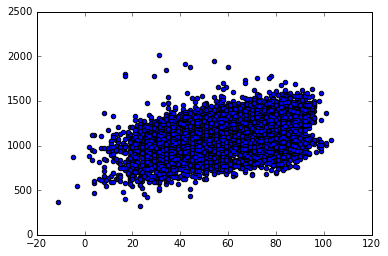

In [58]:
plt.scatter(crime_temp['Temp'], crime_temp['Crime'])

The really hot and really cold days appear to be the farthest from the trendline.  This makes sense, warm days might be associated with increased crime, but over a certain threshold it can become bad weather.

Float64Index([-11.0,  -5.0,  -3.0,   2.0,   3.0,   4.0,   6.0,   7.0,   8.0,
                9.0,
              ...
               92.0,  93.0,  94.0,  95.0,  96.0,  97.0,  98.0,  99.0, 101.0,
              103.0],
             dtype='float64', name='Temp', length=102)


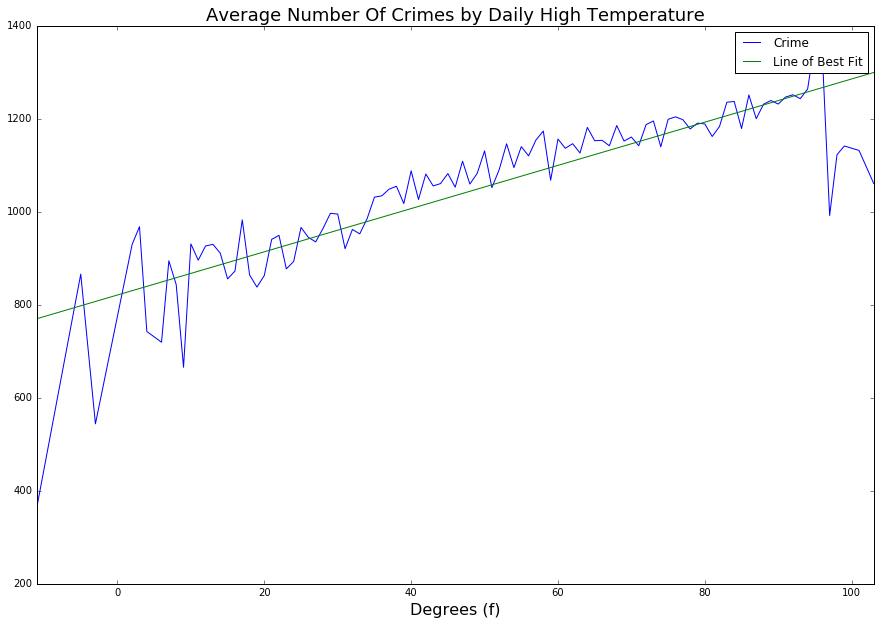

In [59]:
crime_temp.groupby('Temp').aggregate(np.mean).plot(figsize=(15,10))
x = crime_temp.groupby('Temp').aggregate(np.mean).index
y = crime_temp.groupby('Temp').aggregate(np.mean)
print(x)
m, b = np.polyfit(x, y , 1)
plt.plot(x, np.array([m*xx + b for xx in x]))
plt.title('Average Number Of Crimes by Daily High Temperature', fontsize=18)
plt.xlabel('Degrees (f)', fontsize=16)
plt.ylabel('', fontsize=16)
plt.legend(['Crime', 'Line of Best Fit'])

Let's see how rain and snow effect crime

In [60]:
crime_precip = crime_temp.join(aurora[aurora['element'] == 'PRCP'].set_index('Datetime')['value'], how='inner')
crime_precip.columns = ['Crime', 'Temp', 'Precip']
ranges = [-1, 0, 20, 40, 60, 80, 100]
labels = [0, 20, 40, 60, 80, 100]
crime_precip['Rain'] = pd.cut(crime_precip.Precip, ranges, labels=labels).astype('category')
crime_precip.head()

,Crime,Temp,Precip,Rain
2001-01-01,1802,17,0,0
2001-01-02,1143,29,0,0
2001-01-03,1151,33,0,0
2001-01-04,1166,38,0,0
2001-01-05,1267,37,0,0


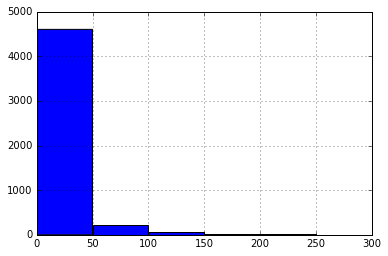

In [61]:
crime_precip['Precip'].hist(bins=[0, 50, 100, 150, 200, 250, 300])

There doesn't seem to be any obvious relationship with rain and crime.  Perhaps the sample size at certain amounts of rain is too small?

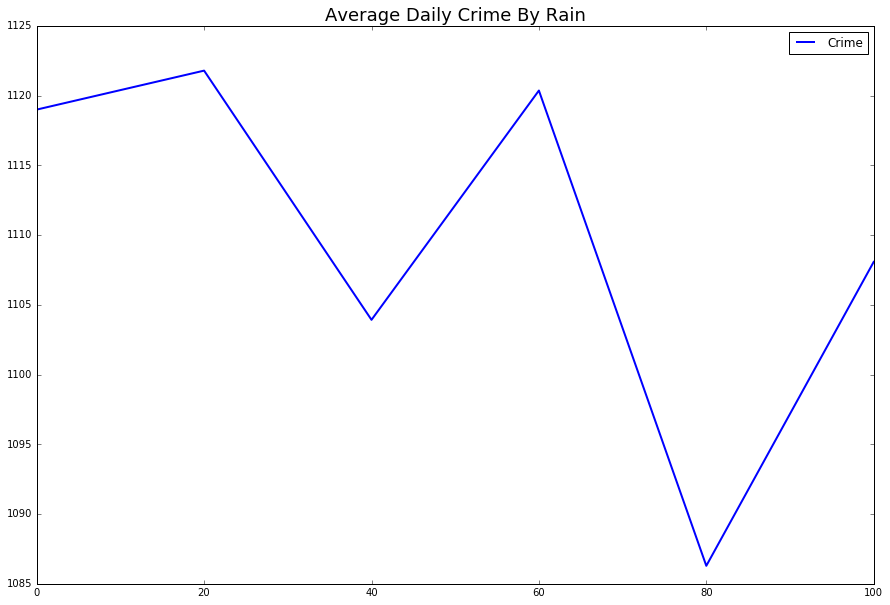

In [63]:
crime_precip[['Crime', 'Rain']].groupby('Rain').aggregate(np.mean).plot(figsize=(15, 10), linewidth=2)
plt.title('Average Daily Crime By Rain', fontsize = 18)
plt.xlabel('Rain (tenths of a mm)', fontsize=16)
plt.xlabel('')

Now we check for snow

In [64]:
crime_snow = crime_precip.join(aurora[aurora['element'] == 'SNOW'].set_index('Datetime')['value'], how='inner')
crime_snow.columns = ['Crime', 'Temp', 'Precip', 'Rain', 'Snow']
crime_snow.head()

,Crime,Temp,Precip,Rain,Snow
2001-01-01,1802,17,0,0,0
2001-01-02,1143,29,0,0,0
2001-01-03,1151,33,0,0,0
2001-01-04,1166,38,0,0,0
2001-01-05,1267,37,0,0,0


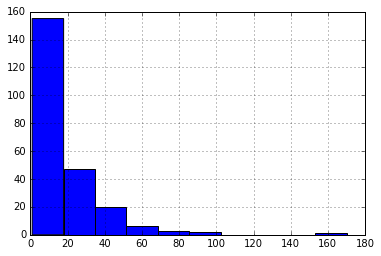

In [65]:
crime_snow['Snow'][crime_snow['Snow'] > 0].hist()

In [66]:
ranges = [-1, 0, 20, 40, 60, 80, 100]
labels = [0, 20, 40, 60, 80, 100]
crime_snow['Snowb'] = pd.cut(crime_snow.Snow, ranges, labels=labels).astype('category')
crime_snow.head(10)

,Crime,Temp,Precip,Rain,Snow,Snowb
2001-01-01,1802,17,0,0,0,0
2001-01-02,1143,29,0,0,0,0
2001-01-03,1151,33,0,0,0,0
2001-01-04,1166,38,0,0,0,0
2001-01-05,1267,37,0,0,0,0
2001-01-06,1290,35,0,0,0,0
2001-01-07,1104,28,0,0,0,0
2001-01-08,1157,25,0,0,0,0
2001-01-09,1184,36,0,0,0,0
2001-01-10,1237,38,0,0,0,0


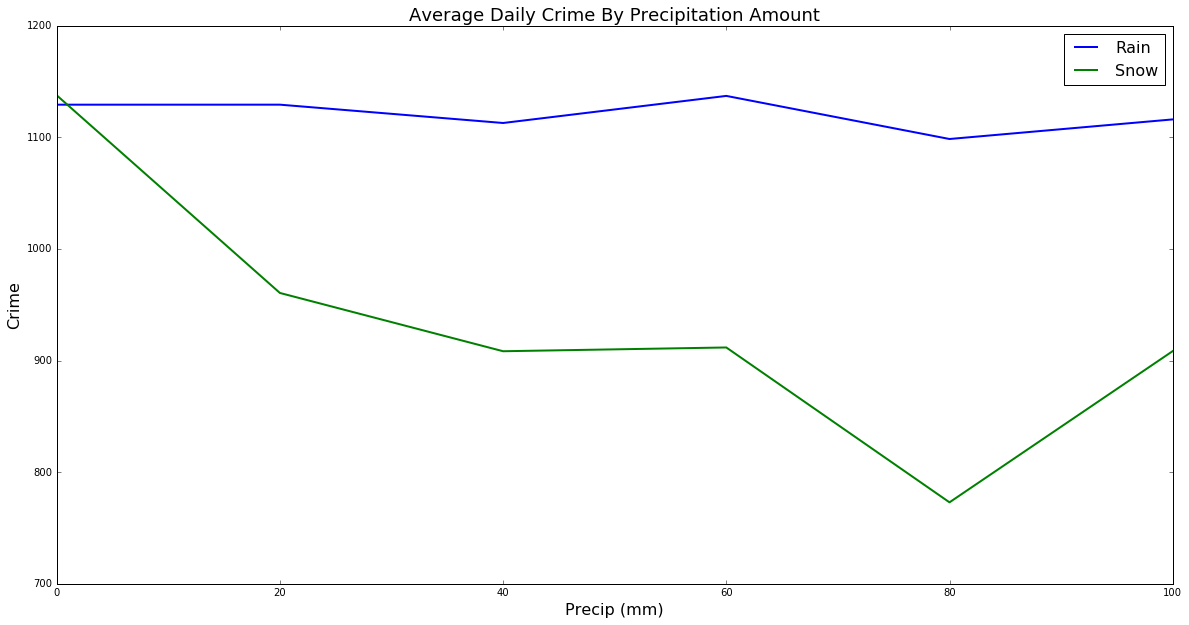

In [67]:
x = [0, 20, 40, 60, 80, 100]
y = crime_snow[['Crime', 'Rain']].groupby('Rain').aggregate(np.mean).Crime
y2 = crime_snow[['Crime', 'Snowb']].groupby('Snowb').aggregate(np.mean).Crime
plt.figure(figsize=(20, 10))
plt.plot(x, y, linewidth=2)
plt.plot(x, y2, linewidth=2)

plt.ylim([700, 1200])
plt.title('Average Daily Crime By Precipitation Amount', fontsize=18)
plt.xlabel('Precip (mm)', fontsize=16)
plt.ylabel('Crime', fontsize = 16)
plt.legend(['Rain', 'Snow'], fontsize=16)